# Figure X. Temperature

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

In [2]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            result = json.load(text_file)
                            record = pd.DataFrame(
                                result['annotations']
                            ).reindex(
                                columns=['Noisy ABL1 pIC50', 'Noisy Log P', 'Noisy Log S',
                                         'ABL1 pIC50', 'Log P', 'Log S']
                            )

                            value = result[measure]
                            trial_indices[value] += 1
                            record[measure] = value
                            record['trial'] = trial_indices[value]
                            
                            records.append(record)
                            result = None
                        except:
                            continue
    return records

paths = [
    '../../dgym-data/analysis/temperature/selection_temperature_2024-05-03_11-15-29.zip',
]

measure = 'temperature_index'
records = []
for path in paths:
    records.extend(get_records(path, measure))

df_raw = pd.concat(records)
records = None

  0%|          | 0/2100 [00:00<?, ?it/s]

In [3]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction([
    docking_utility_function, log_P_utility_function, log_S_utility_function])

In [4]:
records = []
for (value, trial), data in tqdm(df_raw.groupby([measure, 'trial'])):
    utility = composite_utility_function(data.values, precompute=True, method='average')
    try:
        cost = utility.index(1.0)
        success = 1
    except:
        cost = len(utility)
        success = 0

    record = {measure: value, 'trial': trial, 'outcome': success, 'cost': cost}
    records.append(record)

df = pd.DataFrame(records)

  0%|          | 0/2097 [00:00<?, ?it/s]

Plotting adjusted outcomes.

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
max_cost = df['cost'].max()
timeline = np.linspace(0, max_cost, 1000) # 500

ecdfs = []
for idx, (value, group) \
    in enumerate(df.groupby(measure)):
    
    # Create Kaplan-Meier object
    kmf = KaplanMeierFitter()

    # Fit data
    kmf.fit(
        durations=group['cost'],
        event_observed=group['outcome'],
        timeline=timeline,
        alpha=0.32
    )
    
    # add confidence intervals
    ecdf_ = pd.merge(
        kmf.cumulative_density_,
        right=kmf.confidence_interval_cumulative_density_,
        left_index=True,
        right_index=True
    ).reset_index()
    
    ecdf_[measure] = value
    ecdfs.append(ecdf_)

ecdf = pd.concat(ecdfs)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


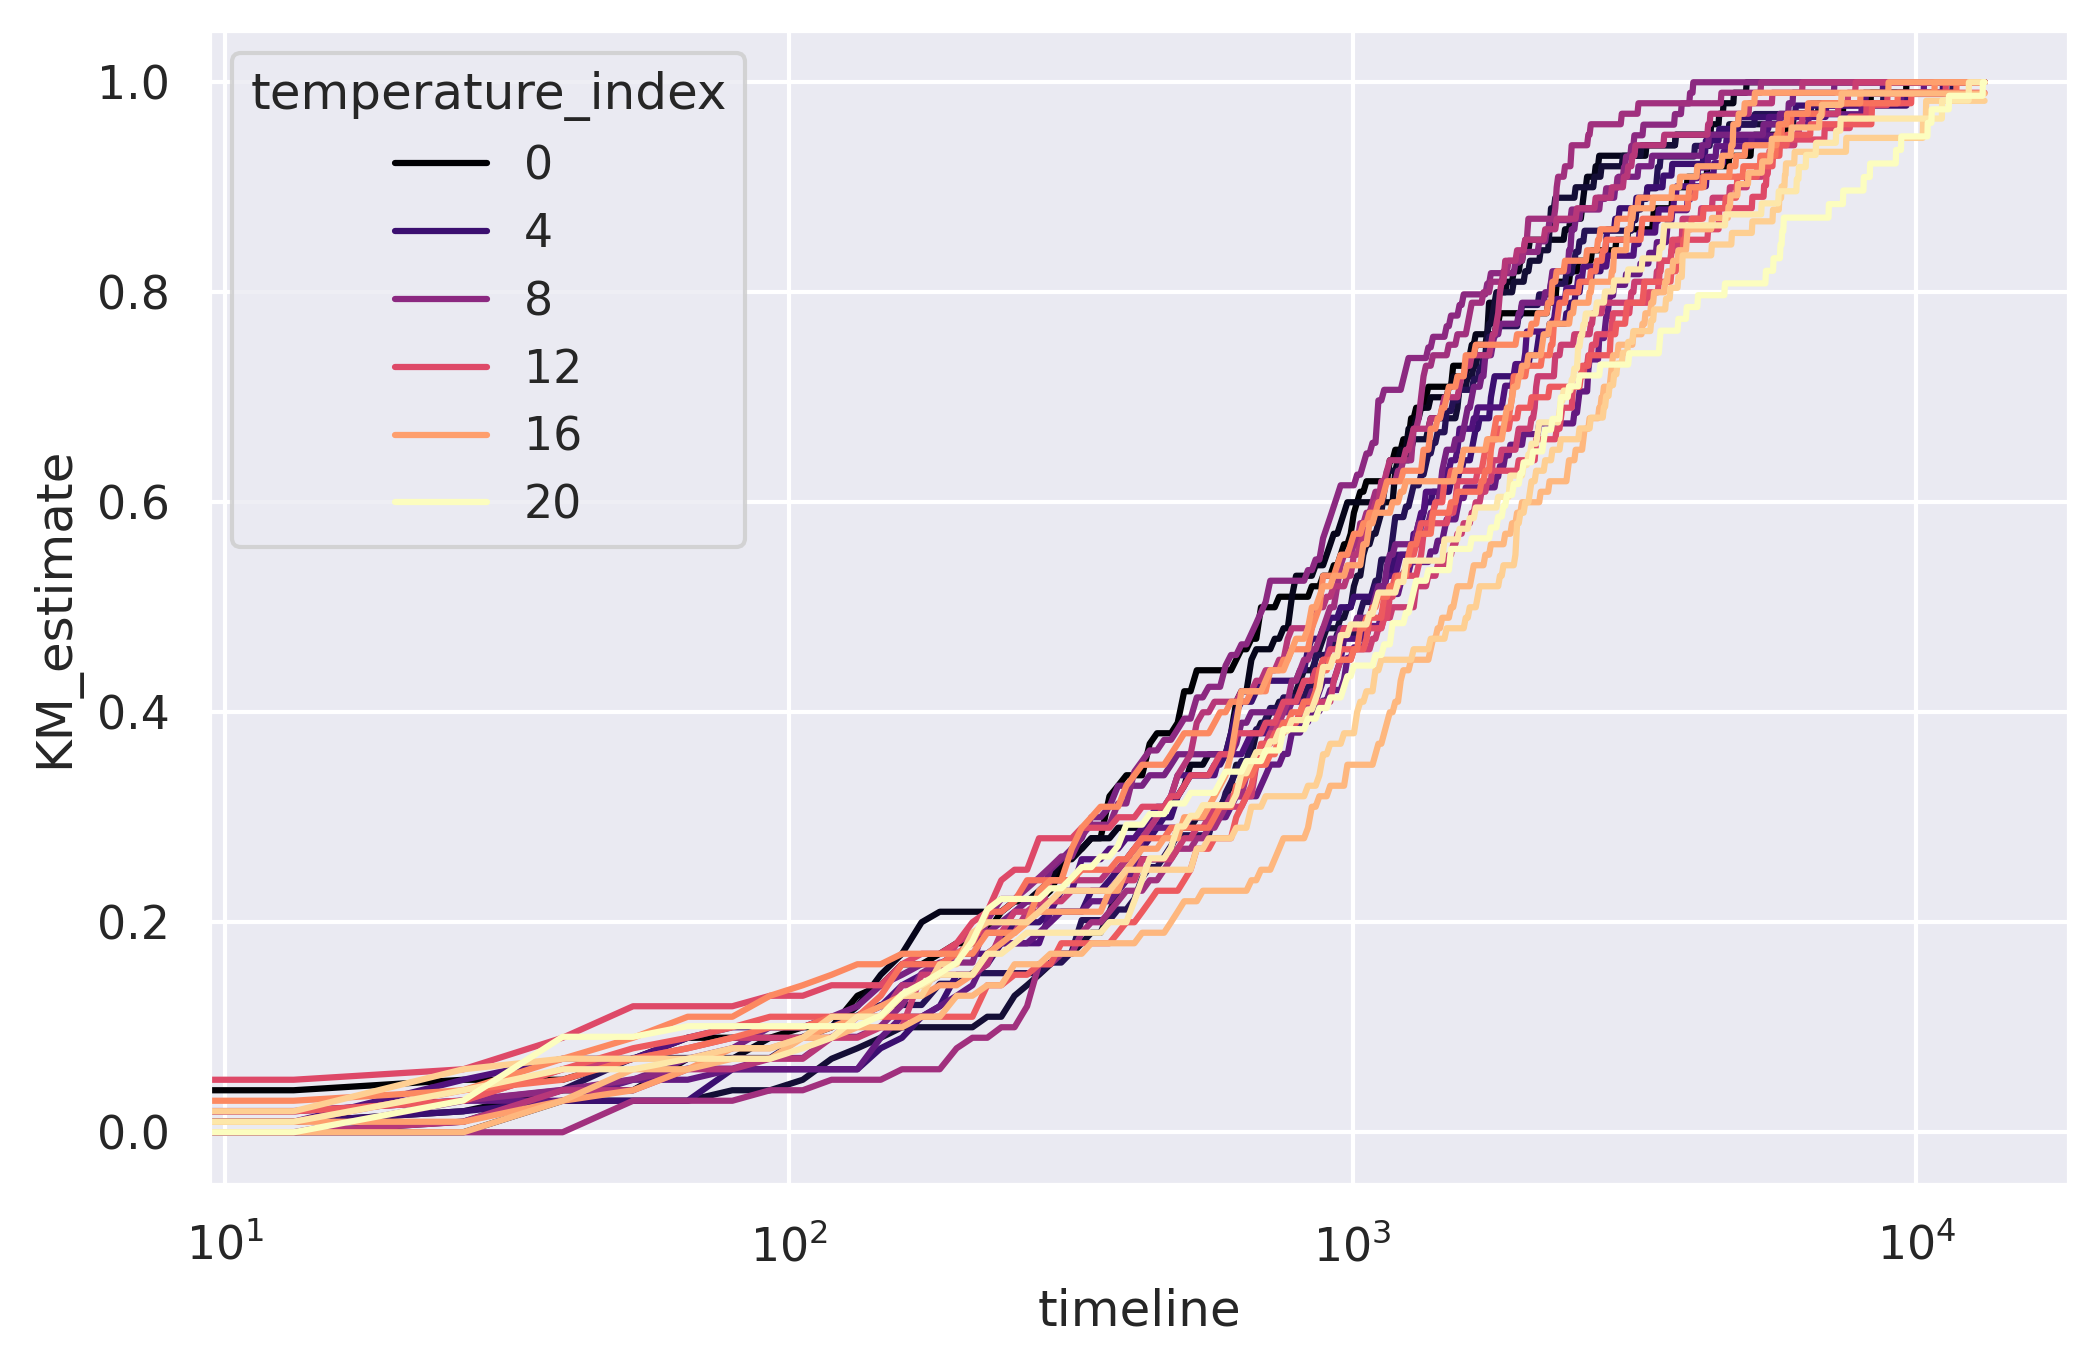

In [153]:
import seaborn as sns

plt.figure(figsize=(8, 5), dpi=300)

sns.set()
g = sns.lineplot(
    ecdf,
    x='timeline',
    y='KM_estimate',
    hue=measure,
    palette='magma'
)

# colormap = sns.palettes.get_colormap('flare')
# colors = colormap.resampled(len(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)))

# for idx, (name, group) in enumerate(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)):
#     g.fill_between(
#         group['timeline'],
#         group['KM_estimate_lower_0.68'],
#         group['KM_estimate_upper_0.68'],
#         alpha=0.2,
#         color=colors.colors[idx]
#     )

# plt.legend(title='Temperature')
# plt.xlabel('Cost (Molecules Tested)')
# plt.ylabel('Cumulative Probability')
# # plt.xlim(-0.05, 1000)
# plt.ylim(-0.05, 1.05)
plt.xscale('log')
# plt.title('Cumulative probability of success versus model error ($\sigma$)')

Plotting below is an old version.

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


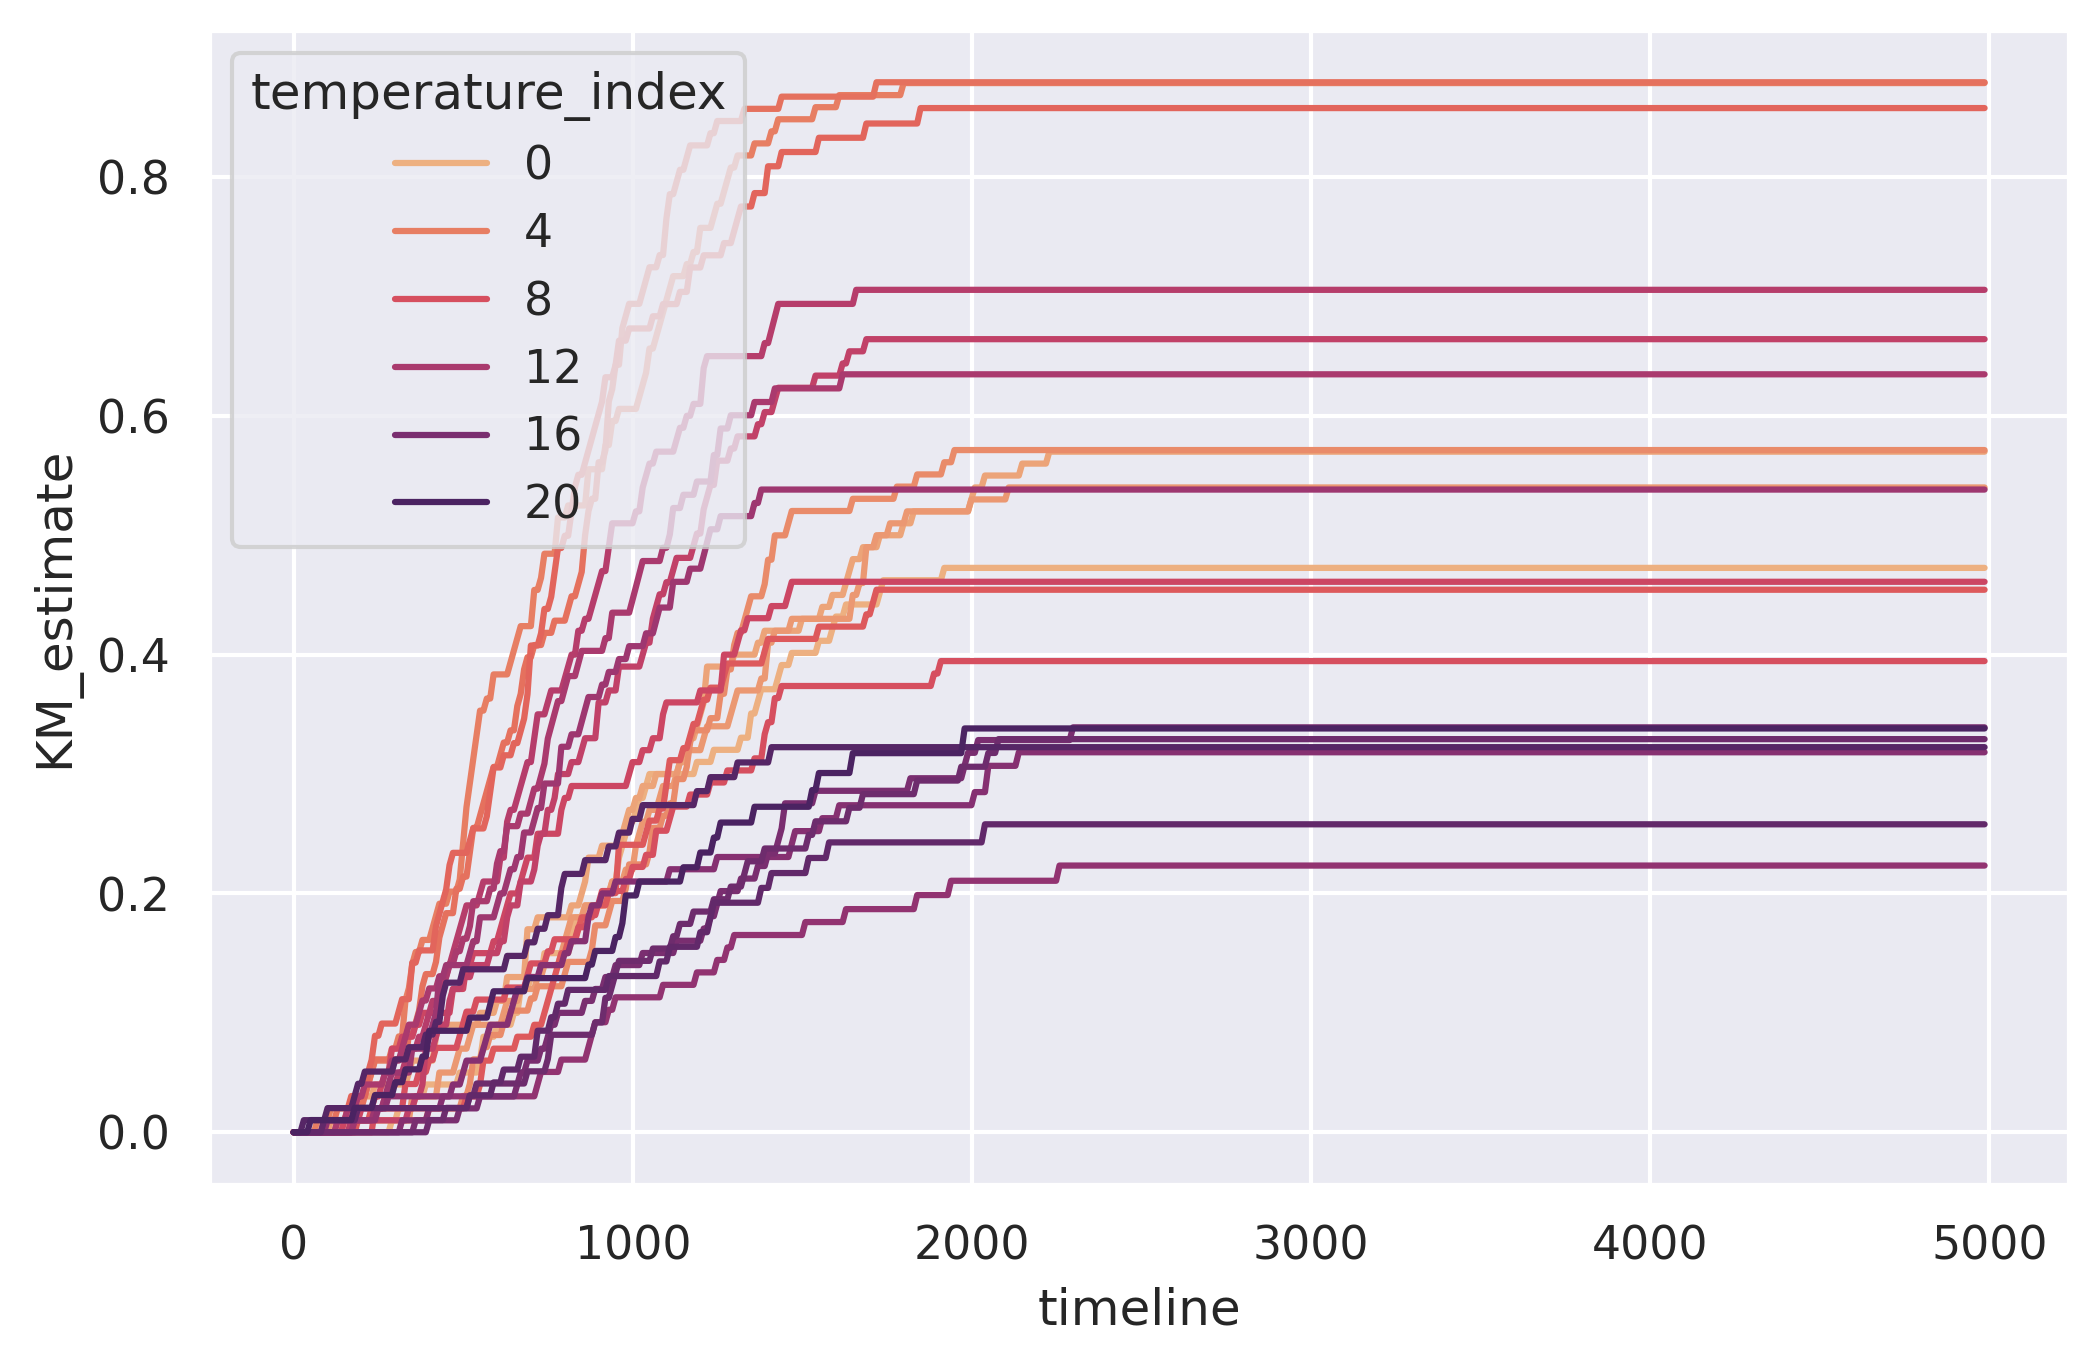

In [48]:
import seaborn as sns

plt.figure(figsize=(8, 5), dpi=300)

sns.set()
g = sns.lineplot(
    ecdf,
    x='timeline',
    y='KM_estimate',
    hue=measure,
    palette='flare'
)

# colormap = sns.palettes.get_colormap('flare')
# colors = colormap.resampled(len(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)))

# for idx, (name, group) in enumerate(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)):
#     g.fill_between(
#         group['timeline'],
#         group['KM_estimate_lower_0.68'],
#         group['KM_estimate_upper_0.68'],
#         alpha=0.2,
#         color=colors.colors[idx]
#     )

# plt.legend(title='Temperature')
# plt.xlabel('Cost (Molecules Tested)')
# plt.ylabel('Cumulative Probability')
# # plt.xlim(-0.05, 1000)
# plt.ylim(-0.05, 1.05)
# plt.title('Cumulative probability of success versus model error ($\sigma$)')

### Plot variable vs. outcome

In [149]:
def closest_budgets(df, target_budgets, budget_var, measure_var):
    """
    Filters the DataFrame to get the budgets that are closest to the target budgets within each setting of 'variable'.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least two columns: 'budget' and 'variable'.
    target_budgets : list of float
        List of target budgets to compare against.
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the rows with budgets closest to the target budgets within each setting of 'variable'.
    """
    def find_and_replace(df_group, targets):
        closest_rows = []
        for target in targets:
            # Filter for budgets that are less than or equal to the target budget
            filtered_df = df_group[df_group[budget_var] <= target]
            if not filtered_df.empty:
                # Find the closest budget less than or equal to the target budget
                closest_row = filtered_df.loc[(filtered_df[budget_var] - target).abs().idxmin()]
                closest_row[budget_var] = target
                closest_rows.append(closest_row)
        return pd.DataFrame(closest_rows)

    return df.groupby(measure_var).apply(find_and_replace, targets=target_budgets).reset_index(drop=True)

## Decoding the temperature and # reactants changed

In [171]:
routines = [
    {'temperature': 0.0, 'limit': 1},
    {'temperature': 0.02, 'limit': 1},
    {'temperature': 0.04, 'limit': 1},
    {'temperature': 0.08, 'limit': 1},
    {'temperature': 0.16, 'limit': 1},
    {'temperature': 0.32, 'limit': 1},
    {'temperature': 0.64, 'limit': 1},
    {'temperature': 0.0, 'limit': 2},
    {'temperature': 0.02, 'limit': 2},
    {'temperature': 0.04, 'limit': 2},
    {'temperature': 0.08, 'limit': 2},
    {'temperature': 0.16, 'limit': 2},
    {'temperature': 0.32, 'limit': 2},
    {'temperature': 0.64, 'limit': 2},
    {'temperature': 0.0, 'limit': 10},
    {'temperature': 0.02, 'limit': 10},
    {'temperature': 0.04, 'limit': 10},
    {'temperature': 0.08, 'limit': 10},
    {'temperature': 0.16, 'limit': 10},
    {'temperature': 0.32, 'limit': 10},
    {'temperature': 0.64, 'limit': 10}
]

ecdf['temperature'] = ecdf['temperature_index'].apply(
    [r['temperature'] for r in routines].__getitem__)
ecdf['# reactants changed'] = ecdf['temperature_index'].apply(
    [r['limit'] for r in routines].__getitem__)
ecdf['# reactants changed'] = \
    ecdf['# reactants changed'].apply(lambda x: 'all' if x == 10 else x)

## Plotting success rates at fixed budgets

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0, 0.5, 'Success Rate @ 3200 mols')

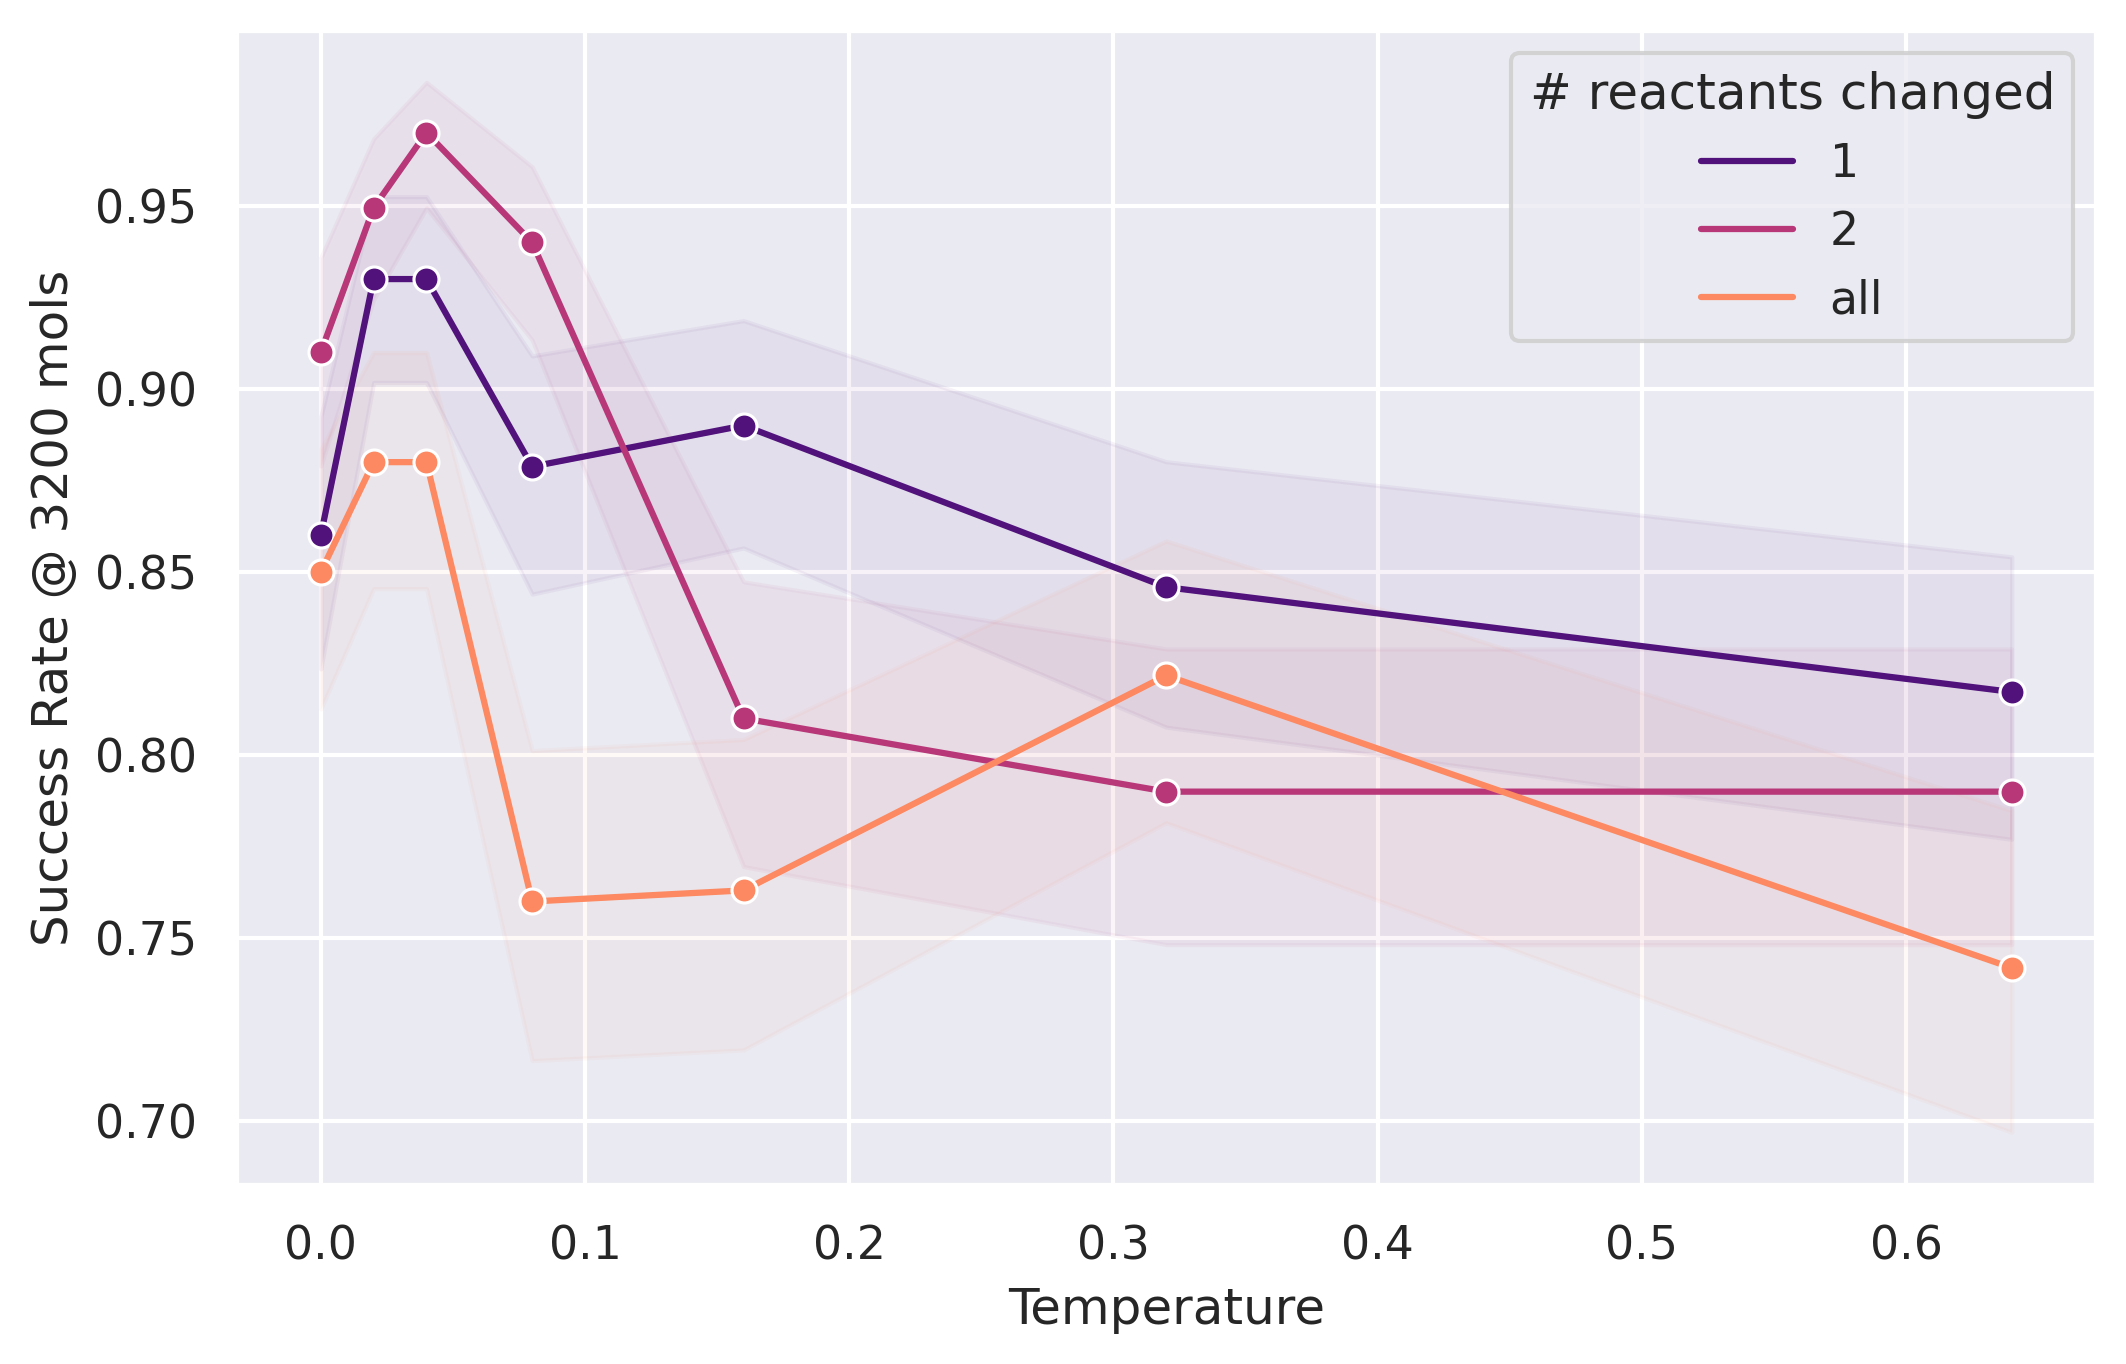

In [233]:
import seaborn as sns
sns.set()
plt.figure(figsize=(8, 5), dpi=300)

budget = 3200

# filtered = ecdf.query(
#     f'{budget} < timeline < {budget} + 10')
filtered = closest_budgets(
    ecdf,
    target_budgets=[budget, 400, 800, 1000, 1100, 1200, 1400, 1600, 2000, 3200, 6400],
    budget_var='timeline',
    measure_var=['temperature', '# reactants changed']
)

colors = sns.color_palette(
    'magma', len(filtered['# reactants changed'].unique()))
g = sns.lineplot(
    filtered.query(f'timeline == {budget}'),
    x='temperature',
    y='KM_estimate',
    hue='# reactants changed',
    palette=colors,
    marker='o',
    ci=False
)

for idx, (name, group) in enumerate(
    filtered
    .query(f'timeline == {budget}')
    .groupby('# reactants changed')
):
    g.fill_between(
        group['temperature'],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.05,
        color=colors[idx],
    )

# plt.ylim(-0.05, 1.05)
plt.xlabel('Temperature')
plt.ylabel(f'Success Rate @ {budget} mols')
# plt.title(f'Success rate versus temperature setting | Budget = {budget} molecules')

## Minimum expected costs to achieve probability of success

In [157]:
def closest_success_rate(df, target_success_rates, success_rate_var, measure_var):
    """
    Filters the DataFrame to get the budgets that are closest to the target budgets within each setting of 'variable'.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least two columns: 'budget' and 'variable'.
    target_budgets : list of float
        List of target budgets to compare against.
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the rows with budgets closest to the target budgets within each setting of 'variable'.
    """
    def find_and_replace(df_group, targets):
        closest_rows = []
        for target in targets:
            # Filter for success rates that are at least the target success rate
            filtered_df = df_group # [df_group[success_rate_var] >= target]
            if not filtered_df.empty:
                # Find the closest budget less than or equal to the target budget
                closest_row = filtered_df.loc[(filtered_df[success_rate_var] - target).abs().idxmin()]
                closest_row['Success Rate'] = target
                closest_rows.append(closest_row)
        return pd.DataFrame(closest_rows)

    return df.groupby(measure_var).apply(find_and_replace, targets=target_success_rates).reset_index(drop=True)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

Text(0, 0.5, 'Cost @ 0.95 Success Rate')

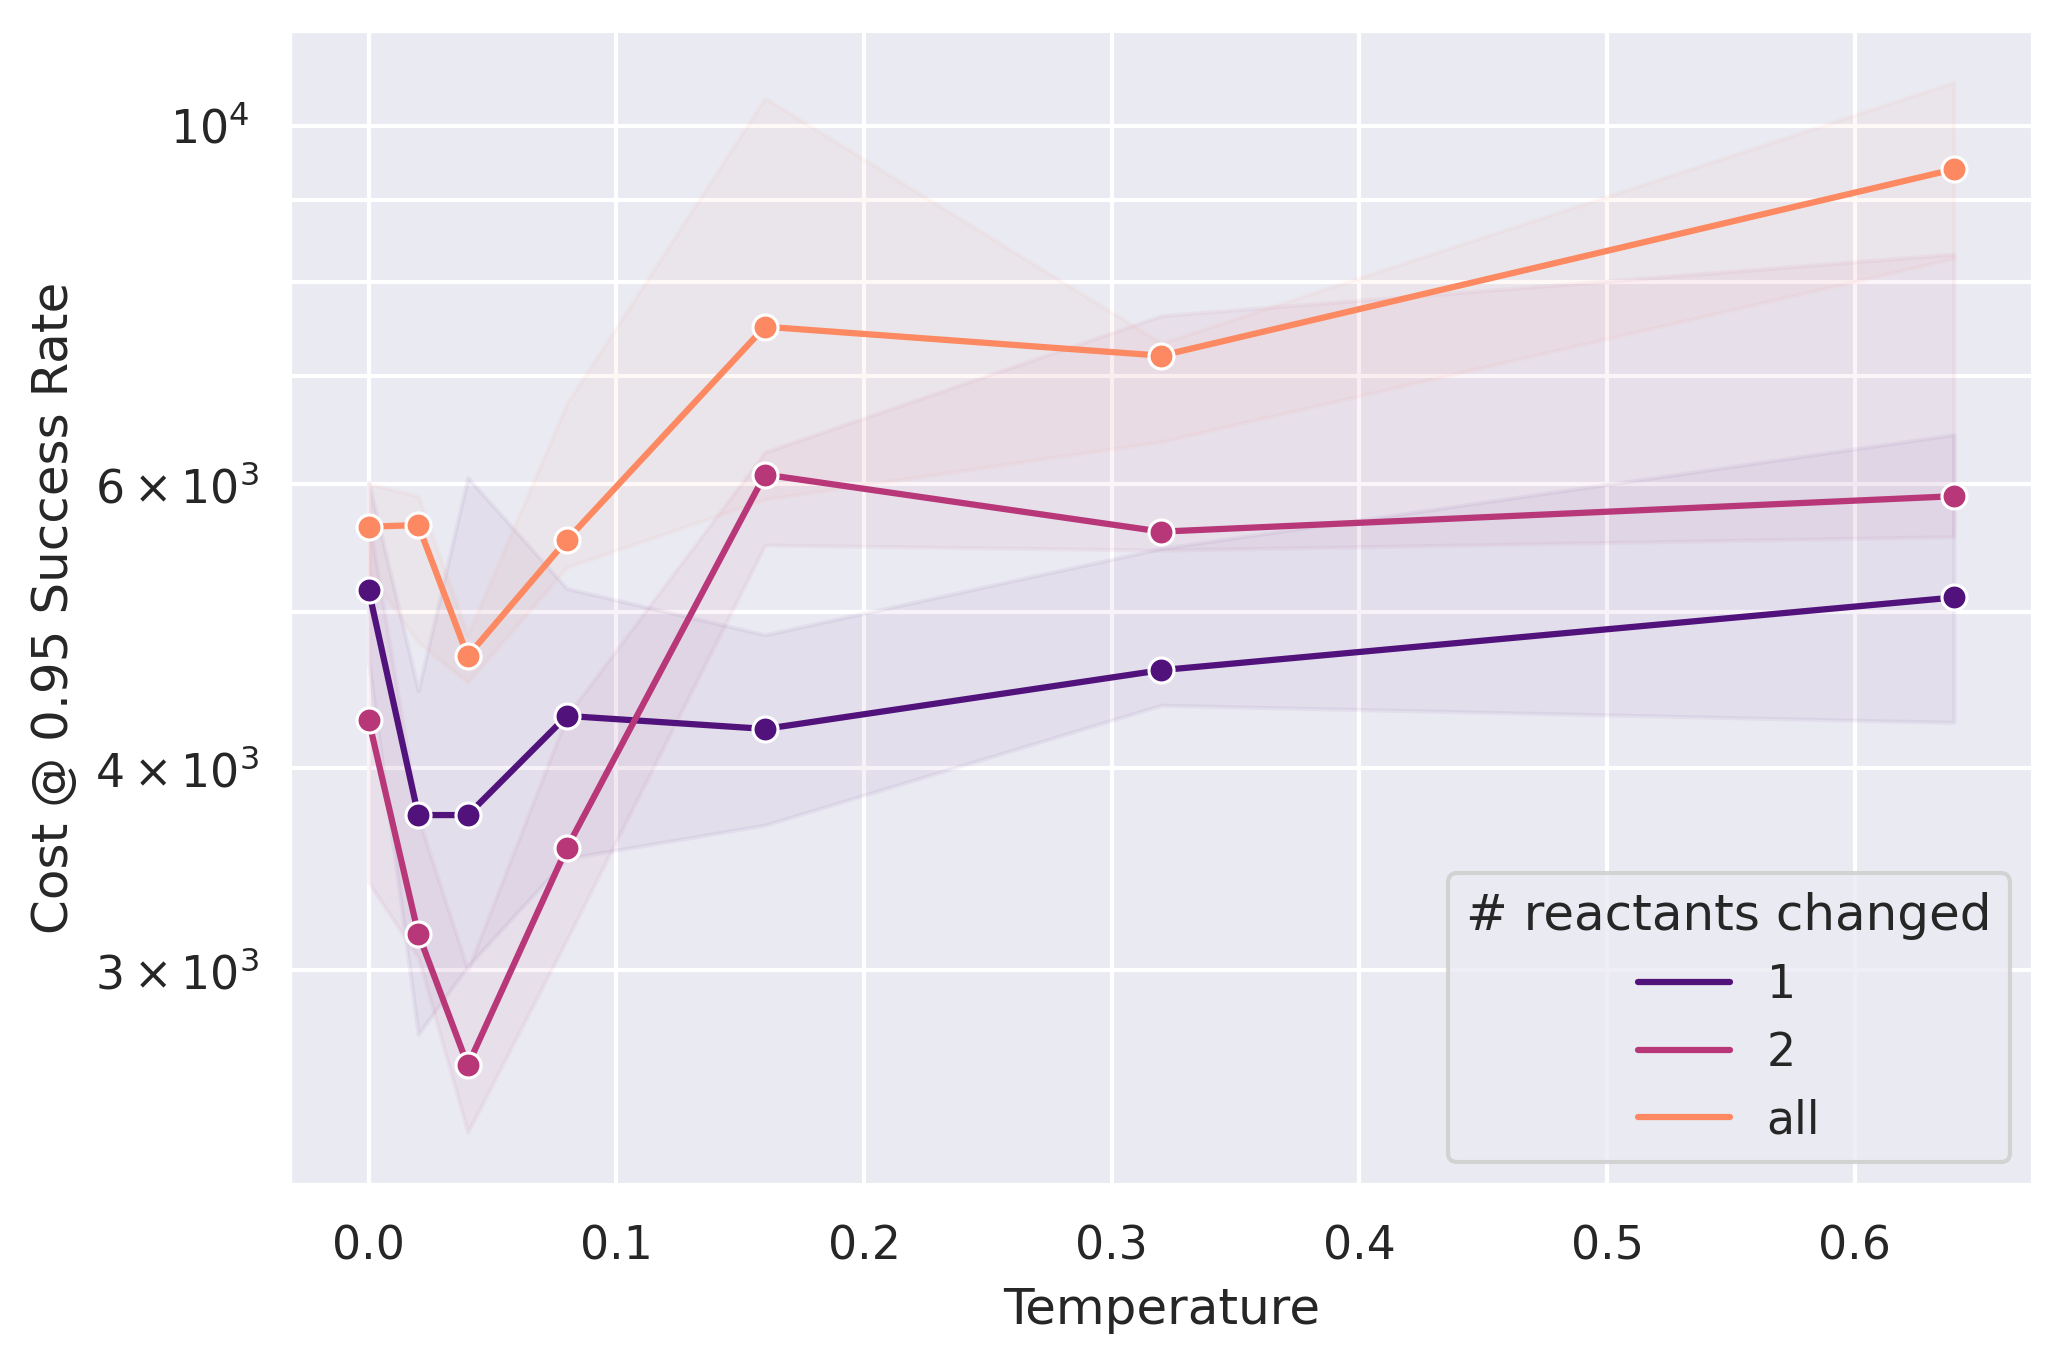

In [240]:
import matplotlib.ticker as ticker
plt.figure(figsize=(7.5, 5), dpi=300)

success_rates = [0.95]
prob = closest_success_rate(
    ecdf, success_rates, 'KM_estimate', ['temperature', '# reactants changed'])
prob_low = closest_success_rate(
    ecdf, success_rates, 'KM_estimate_lower_0.68', ['temperature', '# reactants changed'])
prob_high = closest_success_rate(
    ecdf, success_rates, 'KM_estimate_upper_0.68', ['temperature', '# reactants changed'])

g = sns.lineplot(
    prob,
    x='temperature',
    y='timeline',
    marker='o',
    # hue='Success Rate',
    hue='# reactants changed',
    ci=False,
    palette=colors,
)

for idx, num_changed in enumerate([1, 2, 'all']):
    g.fill_between(
        prob[prob['# reactants changed'] == num_changed]['temperature'],
        prob_low[prob_low['# reactants changed'] == num_changed]['timeline'],
        prob_high[prob_high['# reactants changed'] == num_changed]['timeline'],
        alpha=0.05,
        color=colors[idx]
    )

# iterate through each axes
g.grid(True, which="both", axis='y')
locmin = ticker.LogLocator(
    base=10,
    subs=np.arange(0.1, 1, 0.1),
    numticks=10
)
g.yaxis.set_minor_locator(locmin)
plt.yscale('log')
# g.set_xticks([0, 5, 10, 15, 20, 25, ])
# Ensure the y-axis starts at 0
# g.set_ylim(bottom=80)
plt.xlabel('Temperature')
plt.ylabel(f'Cost @ {success_rates[0]} Success Rate')
# plt.title(f'Expected cost versus ratio designed:made')